# Hot word detection task

In [ ]:
from pathlib import Path
from IPython.display import Audio
import torchaudio
from torch import tensor

In [ ]:
#|default_exp hits.data

In [ ]:
#|export
import requests
import librosa, matplotlib.pyplot as plt, numpy as np
from fastcore.all import noop, L

See main task [here](https://github.com/MenshikovDmitry/TSU_AI_Course/blob/main/module_3.%20Sound%20Processing%20ang%20hot-word%20detection/README.md)

In [ ]:
#|export
def load_stream(file = '../data/stream.mp3'):
    stream_url = 'https://radio.kotah.ru/soundcheck'
    r = requests.get(stream_url, stream=True)
    with open(file, 'wb') as f:
        try:
            for block in r.iter_content(4096):
                f.write(block)
        except KeyboardInterrupt:
            pass

In [ ]:
path_stones = Path('../data/stones')
files = path_stones.ls()
path = Path('../data/stream.mp3')
sr = 16_000
max_length_s = 1.2 # seconds
max_l = int(max_length_s*sr)

In [ ]:
s, sr = librosa.load(path, sr=sr)

In [ ]:
#|export
def split_into_frames(arr, f_size, stride):
    n_frames = (arr.shape[0] - f_size)//stride + 1
    strides = (stride*arr.dtype.itemsize, arr.dtype.itemsize)
    return np.lib.stride_tricks.as_strided(arr, shape=(n_frames, f_size), strides=strides).copy()

def split_audio(sound, sr, f_size=1, stride=1):
    return split_into_frames(sound, int(sr*f_size), int(sr*stride))

In [ ]:
frames = split_audio(s, sr, f_size=max_length_s, stride=0.8)

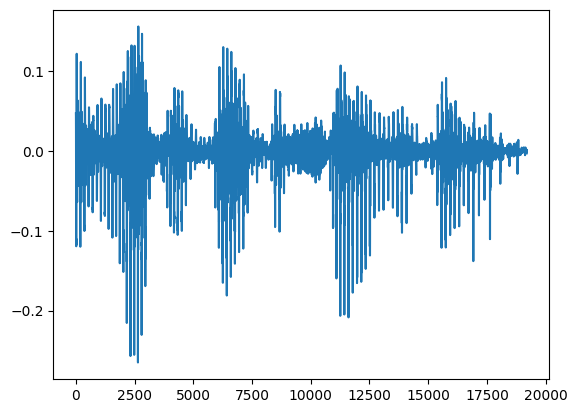

In [ ]:
idx=4
plt.plot(frames[idx])
Audio(frames[idx], rate=sr)

Audio that says 'STONES'

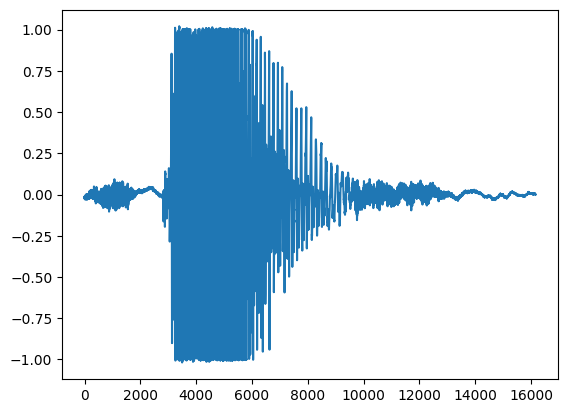

In [ ]:
s, _ = librosa.load(files[0], sr=sr)
plt.plot(s)
Audio(s, rate=sr)

Map to same lengh of `max_length_s` seconds

In [ ]:
stones = L(librosa.load(f, sr=sr)[0] for f in files)
stones = stones.map(lambda a: a[0: max_l] if a.shape[0] > max_l 
                    else np.hstack((a, np.zeros(max_l - a.shape[0], dtype=stones[0].dtype))))
stones = np.stack(stones)

## Create dataset

In [ ]:
frames.shape[0]

1015

In [ ]:
#|export
def generate_with_stones(frames, stones, n=2000):
    stone_samples = stones[np.random.choice(stones.shape[0], n)]
    fr_samples = frames[np.random.choice(frames.shape[0], n)]
    p = np.random.rand(n,1).astype(frames.dtype)*.5
    return (1-p)*stone_samples+p*fr_samples

In [ ]:
n_neg, n_pos = 1500, 1500
# create positive samples that contain key word
xs = generate_with_stones(frames, stones, n_neg)
ys = np.ones(n_neg)

# take negative samples
xs = np.concatenate((xs, frames[np.random.choice(frames.shape[0], n_pos)]))
ys = np.concatenate((ys,np.zeros(n_pos)))

Save to files

In [ ]:
# for i,(x,y) in enumerate(zip(xs,ys)):
#     torchaudio.save(f'../data/{int(y)}/{i}.wav', tensor(x[None]), sr)

### Create basic dataset class

In [ ]:
#|export
def merge_items(xs, ys):
    return [(x,y) for x,y in zip(xs,ys)]

class TfmDataset:
    def __init__(self, items, x_tfms=None, y_tfms=None) -> None:
        self.items = items
        self.x_tfms = [noop] if x_tfms is None else x_tfms
        self.y_tfms = [noop] if y_tfms is None else y_tfms
    
    def __len__(self): return len(self.items)
    
    def __getitem__(self, idx):
        x, y = self.items[idx]
        for t in self.x_tfms: x=t(x)
        for t in self.y_tfms: y=t(y)
        return x,y

In [ ]:
#|export
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

## Tasks:
1. Create train and test dataset
   1. Inputs are little patches of sound
   2. Outputs are true or false depending on wether they contain 'STONES'
   3. To augment true data we can use other audio to add noise
2. Create dataset and dataloader to get xs and ys
3. Try different models 
   1. CNN that has big enough windows that STONES will be detected, just need to now HOW MUCH layers, dropouts and stuff
   2. More advanced based on lectures, dilated convolutions and stuff, but only after tried solutions above
4. Try non ml ([ChatGPT](https://chat.openai.com/share/3a16e0eb-c8d6-43ed-91bb-bc2089ab6d25))
5. Play with different sound processing tools